# Data Preparation

In [2]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

In [3]:
AD =r"D:\final_year_project\dataset\AD_Patients"
NORMAL =r"D:\final_year_project\dataset\NORMAL"
MCI = r"D:\final_year_project\dataset\MCI"

In [4]:
def convertmat2mne(data):
    #Defines a list of channel names for the EEG data.
    ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz' ,'F4',' F8', 'T3', ' C3', 'Cz' , 'C4' , ' T4' , 'T5', ' P3' , 'Pz', ' P4' , 'T6', 'O1','O2']
    
    #Creates a list of channel types for the EEG data. In this case, all channels are of type 'eeg'
    ch_types = ['eeg'] * (len(ch_names))
    
    #Defines the sampling frequency of the EEG data
    sampling_freq = 256 
    
    #Creates an MNE info object, which contains information about the channels and sampling frequency.
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    
    #Loads a standard electrode montage for the 10-20 system.
    montage = mne.channels.make_standard_montage('standard_1020')
    
    #Associates the electrode locations with the channel names in the info object.
    info.set_montage(montage,on_missing='ignore')
    
    #Creates an MNE Raw object from the EEG data and info object.
    data = mne.io.RawArray(data.T, info)
    
    #Applies an average reference to the EEG data.
    data.set_eeg_reference()
    
    #Applies a 0-30 Hz bandpass filter to the EEG data.
    data.filter(l_freq=0.1, h_freq=45)
    
    #Applies a notch filter to remove 50 and 100 Hz line noise from the EEG data
    data.notch_filter(freqs=(50, 100))
    
    #Divides the EEG data into epochs of fixed duration (2 seconds in this case) with no overlap.
    epochs = mne.make_fixed_length_epochs(data, duration=2, overlap=0)
    
    #Returns the data array for all epochs.
    return epochs.get_data()


In [5]:
%%capture
# Empty list to store the MNE data objects for each subject's EEG data
normal_subject = []
# Iterate over all .mat files in the directory specified by the variable Normal
for normal in glob(NORMAL+'/*mat'):
    data = scipy.io.loadmat(normal)
    if 'export' in data:
        data = data['export']
        data = convertmat2mne(data)
        normal_subject.append(data)
    else:
        data = data['data']
        data = convertmat2mne(data)
        normal_subject.append(data)

In [6]:
print(len(normal_subject))

310


In [7]:
%%capture
# Empty list to store the MNE data objects for each subject's EEG data
mci_subject=[]
# Iterate over all .mat files in the directory specified by the variable MCI
for mci in glob(MCI+'/*mat'):
    data = scipy.io.loadmat(mci)
    if 'export' in data:
        data = data['export']
        data = convertmat2mne(data)
        mci_subject.append(data)
    else:
        data = data['data']
        data = convertmat2mne(data)
        mci_subject.append(data)

In [8]:
print(len(mci_subject))

616


In [9]:
%%capture
# Empty list to store the MNE data objects for each subject's EEG data
ad_subject = []
# Iterate over all .mat files in the directory specified by the variable AD
for ad in glob(AD+'/*mat'):
    data = scipy.io.loadmat(ad)
    if 'export' in data:
        data = data['export']
        data = convertmat2mne(data)
        ad_subject.append(data)
    else:
        data = data['data']
        data = convertmat2mne(data)
        ad_subject.append(data)

In [10]:
print(len(ad_subject))

627


In [11]:
# Create a list of labels for each epoch in the Alzheimer's disease group's data
ad_epochs_labels = [len(i) * [0] for i in ad_subject]

# Create a list of labels for each epoch in the mild cognitive impairment group's data
mci_epochs_labels = [len(i) * [1] for i in mci_subject]

# Create a list of labels for each epoch in the normal group's data
normal_epochs_labels = [len(i) * [2] for i in normal_subject]

# Print the number of epochs in each group's data
print(len(ad_epochs_labels), len(mci_epochs_labels), len(normal_epochs_labels))

627 616 310


In [12]:
# Combine the lists of EEG data for all three groups into a single list
data_list = ad_subject + mci_subject + normal_subject

# Combine the lists of labels for all three groups into a single list
label_list = ad_epochs_labels + mci_epochs_labels + normal_epochs_labels

# Create a list of group labels for each epoch in the combined data list
groups_list = [[i] * len(j) for i, j in enumerate(data_list)]

# Print the number of epochs, labels, and group labels in the combined data list
print(len(data_list), len(label_list), len(groups_list))

1553 1553 1553


In [13]:
# concatenate all data from ad_subject, mci_subject, and normal_subject to create a single data array
data_array = np.concatenate(data_list)

# concatenate all labels from ad_epochs_labels, mci_epochs_labels, and normal_epochs_labels to create a single label array
label_array = np.concatenate(label_list)

# concatenate all groups from the groups_list to create a single group array
group_array = np.concatenate(groups_list)

# move the axis at index 1 to index 2, since the model expects the data in the shape (batch, channels, sequence)
data_array = np.moveaxis(data_array, 1, 2)

# print the shape of the data_array, label_array, and group_array
print(data_array.shape, label_array.shape, group_array.shape)


(27703, 512, 19) (27703,) (27703,)


# 1D CNN Model 

In [14]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=32,kernel_size=5,strides=1,input_shape=(512,19)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2
    model.add(Conv1D(filters=64,kernel_size=5,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#6
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=256,kernel_size=5,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#8
    model.add(Conv1D(filters=512,kernel_size=5,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(3, activation='softmax'))#11
    
    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 508, 32)           3072      
                                                                 
 batch_normalization (BatchN  (None, 508, 32)          128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 508, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 254, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 64)           10304     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 250, 64)           0

In [15]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()

In [16]:
from tensorflow.keras.utils import to_categorical


num_classes = len(set(label_array))
label_array_one_hot = to_categorical(label_array, num_classes)


accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array_one_hot, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array_one_hot[train_index]
    val_features,val_labels=data_array[val_index],label_array_one_hot[val_index]
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    break
    

In [17]:
model=cnnmodel()

In [18]:
history = model.fit(train_features,train_labels,epochs=20,batch_size=128,validation_data=(val_features,val_labels))

Epoch 1/20
174/174 [==============================] - 150s 830ms/step - loss: 0.4737 - accuracy: 0.7966 - val_loss: 0.3533 - val_accuracy: 0.8827
Epoch 2/20
174/174 [==============================] - 141s 811ms/step - loss: 0.2060 - accuracy: 0.9219 - val_loss: 0.1824 - val_accuracy: 0.9309
Epoch 3/20
174/174 [==============================] - 149s 853ms/step - loss: 0.1694 - accuracy: 0.9391 - val_loss: 0.4370 - val_accuracy: 0.8603
Epoch 4/20
174/174 [==============================] - 179s 1s/step - loss: 0.1185 - accuracy: 0.9552 - val_loss: 0.2429 - val_accuracy: 0.9256
Epoch 5/20
174/174 [==============================] - 162s 929ms/step - loss: 0.0859 - accuracy: 0.9663 - val_loss: 0.1804 - val_accuracy: 0.9473
Epoch 6/20
174/174 [==============================] - 156s 898ms/step - loss: 0.0805 - accuracy: 0.9686 - val_loss: 0.2497 - val_accuracy: 0.9210
Epoch 7/20
174/174 [==============================] - 142s 818ms/step - loss: 0.0876 - accuracy: 0.9670 - val_loss: 0.2839 - va

In [19]:
model.evaluate(val_features,val_labels)

174/174 [==============================] - 3s 18ms/step - loss: 0.0370 - accuracy: 0.9874


[0.03697191923856735, 0.9873669147491455]

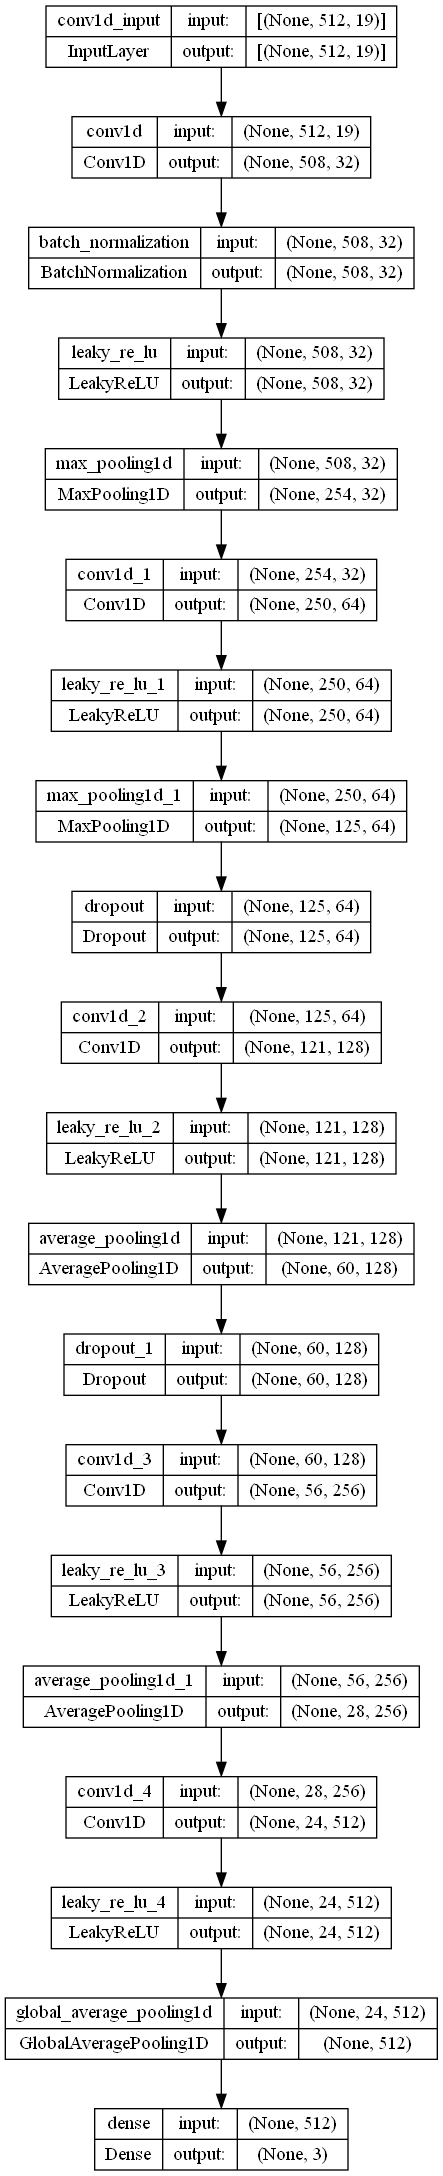

In [19]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model1.png', show_shapes=True)

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

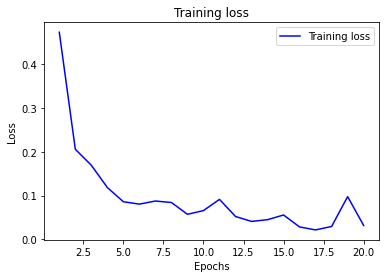

In [21]:
# plot the training loss curves

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



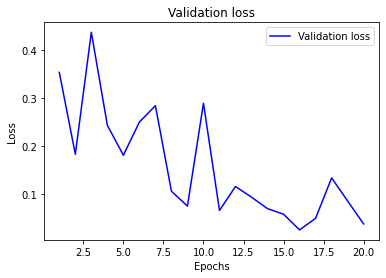

In [22]:
# plot the validation loss curves


val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


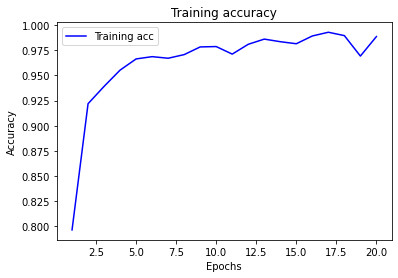

In [23]:
# plot the training accuracy curve

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')

plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

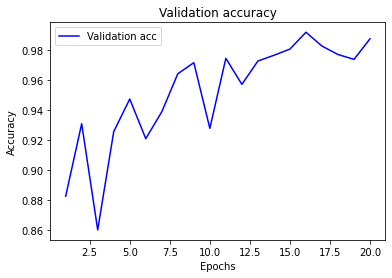

In [24]:
# plot the validation accuracy curve


val_acc = history.history['val_accuracy']
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Create Boolean mask for unknown or missing labels
unknown_mask = np.isnan(val_labels[:, 0])

# Apply Boolean mask to validation features and labels
val_features = val_features[~unknown_mask]
val_labels = val_labels[~unknown_mask]

# Make predictions on the validation set
y_pred = model.predict(val_features)

# Convert predictions from probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# If val_labels is one-hot-encoded, convert it to a 1D array
if val_labels.shape[1] > 1:
    val_labels = np.argmax(val_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(val_labels, y_pred)
print("Confusion matrix:\n", cm)



174/174 [==============================] - 4s 17ms/step
Confusion matrix:
 [[2450    6    0]
 [  60 2267    4]
 [   0    0  754]]


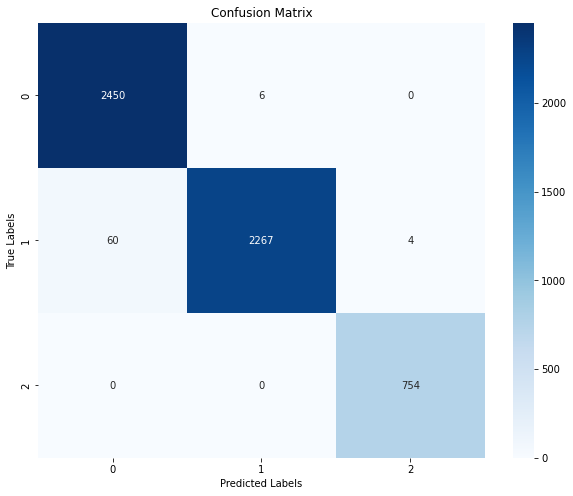

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)

# Set the axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()


In [27]:
# Calculate the classification report
report = classification_report(val_labels, y_pred)
print("Classification report:\n", report)


Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2456
           1       1.00      0.97      0.98      2331
           2       0.99      1.00      1.00       754

    accuracy                           0.99      5541
   macro avg       0.99      0.99      0.99      5541
weighted avg       0.99      0.99      0.99      5541

